### Optimal control of deterministic phenomenological models
This notebook shows how to compute the optimal control (OC) signal for phenomenological models (FHN, Hopf) for a simple example task.

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.models.hopf import HopfModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_fhn
from neurolib.optimal_control import oc_hopf
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [39]:
# We import the model
model = FHNModel()
# model = HopfModel()    # OC can be computed for the Hopf model completely analogously

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 10.
amplitude = 1.
period = duration/4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-2] = np.sin(2.*np.pi*np.arange(0,duration-0.2, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
x_init = 0.
y_init = 0.
model.params["xs_init"] = np.array([[x_init]])
model.params["ys_init"] = np.array([[y_init]])

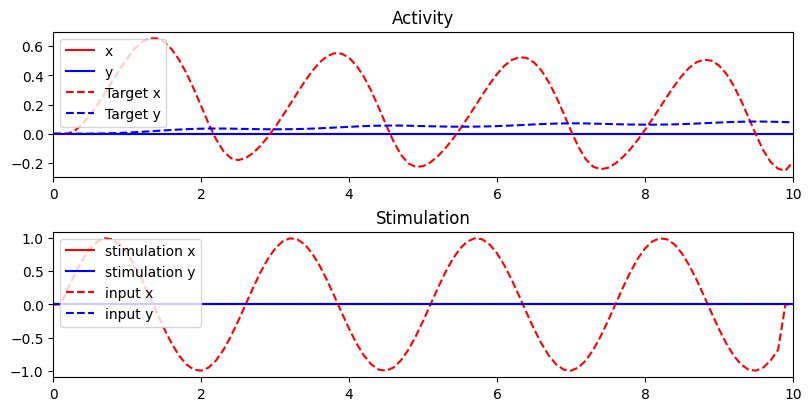

In [40]:
# We set the stimulus in x and y variables, and run the simulation
model.params["x_ext"] = input
model.params["y_ext"] = zero_input
model.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["x_ext"] = zero_input
model.params["y_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

plot_oc_singlenode(duration, dt, state, target, control, target_input)

Optimal control with target time series
{w_p: 1.0, w_f: 0.0, w_phase: 0.0, w_ac: 0.0, w_2: 0.0, w_1: 0.0, w_1T: 0.0, w_1D: 0.0}
Compute control for a deterministic system
Cost in iteration 0: 0.5533851530971279
Cost in iteration 1: 0.5259262993750943
Cost in iteration 2: 0.5121131569310394
Cost in iteration 3: 0.48156504289973884
Cost in iteration 4: 0.4604136398224274
Cost in iteration 5: 0.4428989150300392
Cost in iteration 100: 0.09606458437628632
Final cost : 0.09606458437628632


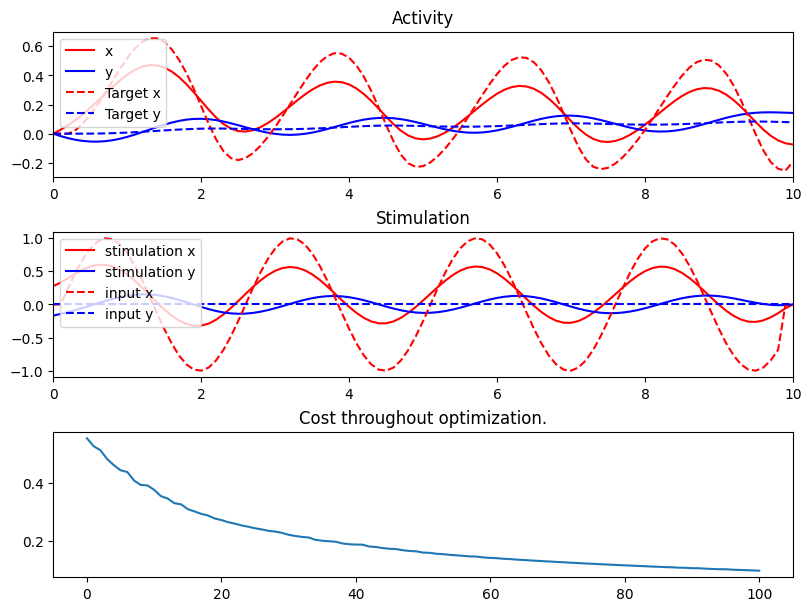

In [49]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model.params["x_ext"] = zero_input
model.params["y_ext"] = zero_input

if model.name == 'fhn':
    model_controlled = oc_fhn.OcFhn(model, target, print_array=[1,2,3,4,5,100,200,300,400,500])
elif model.name == 'hopf':
    model_controlled = oc_hopf.OcHopf(model, target, print_array=[1,2,3,4,5,100,200,300,400,500])

print(model_controlled.weights)
# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

Compute control for a deterministic system
Cost in iteration 0: 0.09606458437628632
Cost in iteration 1: 0.09595167371136451
Cost in iteration 2: 0.09459874680473958
Cost in iteration 3: 0.09373056973195033
Cost in iteration 4: 0.0929922506521303
Cost in iteration 5: 0.09219017739810004
Cost in iteration 100: 0.046820879161951934
Final cost : 0.046820879161951934


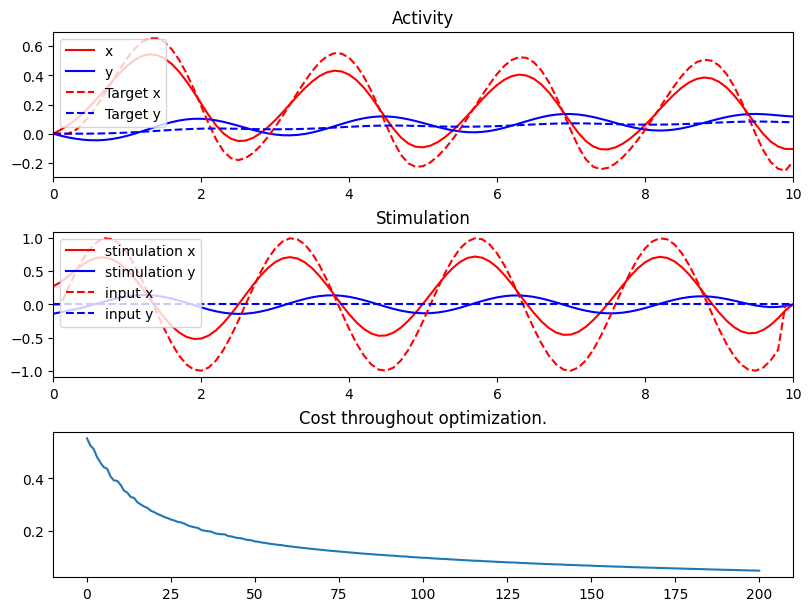

In [50]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

### Network case

Let us know study a simple 2-node network of FHN oscillators. We first need to define the coupling matrix and the delay matrix. We can then initialize the model.

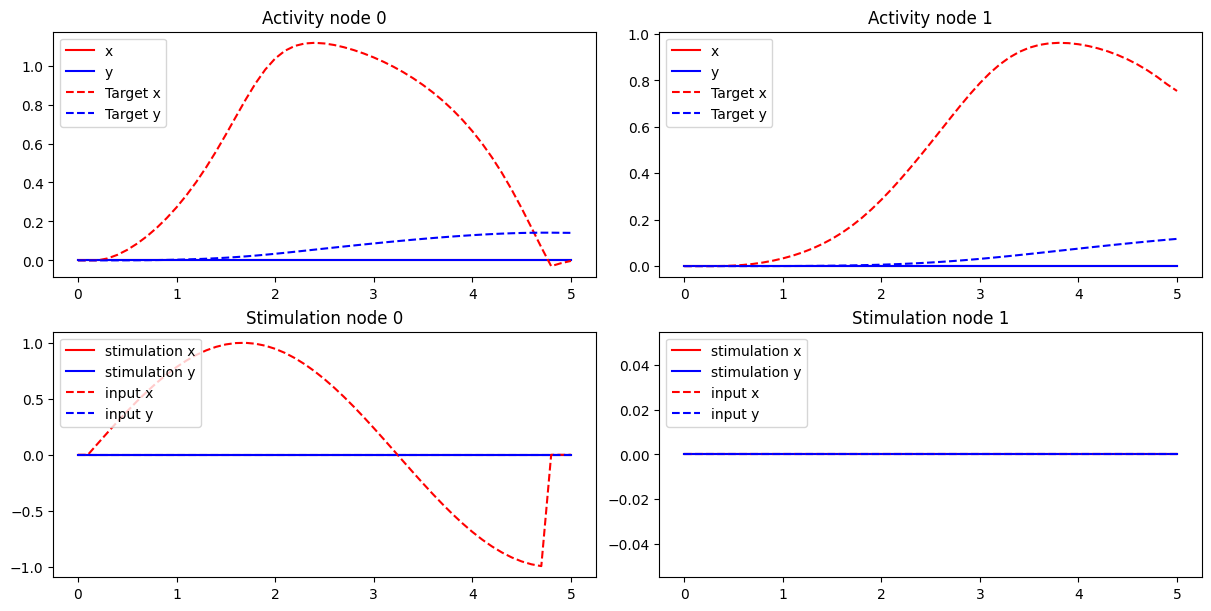

In [87]:
cmat = np.array( [[0., 0.5], [1., 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

if model.name == 'fhn':
    model = FHNModel(Cmat=cmat, Dmat=dmat)
elif model.name == 'hopf':
    model = HopfModel(Cmat=cmat, Dmat=dmat)
model.params.coupling = "additive" # use additive coupling

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in y-channel in node 0

if control_mat[0,0] == 0. and control_mat[1,0] == 0:
    # if x is input channel, high connection strength can lead to numerical issues
    model.params.K_gl = 5. # increase for stronger connectivity, WARNING: too high value will cause numerical problems

model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-3] = np.sin(np.arange(0,duration-0.3, dt)) # other functions or random values can be used as well
model.params["xs_init"] = np.vstack( [x_init, x_init] )
model.params["ys_init"] = np.vstack( [y_init, y_init] )



# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["x_ext"] = input_nw[:,0,:]
model.params["y_ext"] = input_nw[:,1,:]

model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Optimal control with target time series
Compute control for a deterministic system
Cost in iteration 0: 0.9873326207953821
Cost in iteration 1: 0.19824144898897755
Cost in iteration 2: 0.06766518326208486
Cost in iteration 10: 0.03313229022296295
Cost in iteration 50: 0.011816652623371286
Cost in iteration 100: 0.0075274626316180265
Final cost : 0.0075274626316180265


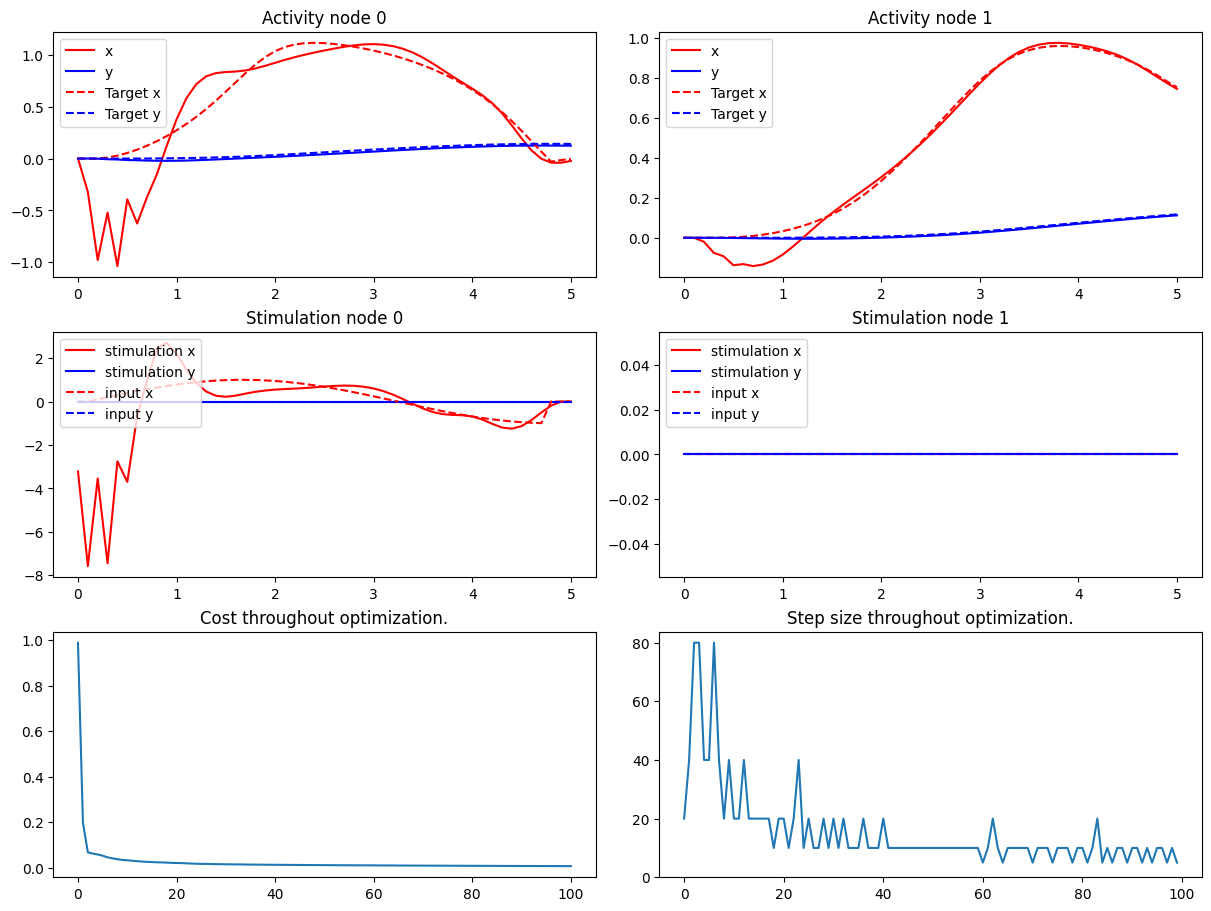

In [88]:
prec_mat = np.zeros( (model.params.N, len(model.output_vars)) )
prec_mat[1,0] = 1. # only measure in y-channel in node 1

model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]

if model.name == 'fhn':
    model_controlled = oc_fhn.OcFhn(model, target, print_array=[1,2,10,50,100,200,300,400,500], control_matrix=control_mat, cost_matrix=prec_mat)
elif model.name == 'hopf':
    model_controlled = oc_hopf.OcHopf(model, target, wprint_array=[1,2,10,50,100,200,300,400,500], control_matrix=control_mat, cost_matrix=prec_mat)

model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 0.0075274626316180265
Cost in iteration 1: 0.0074731271820453115
Cost in iteration 2: 0.007453403255024061
Cost in iteration 10: 0.007035268662607566
Cost in iteration 50: 0.005501135541363303
Cost in iteration 100: 0.004047265501237506
Final cost : 0.004047265501237506


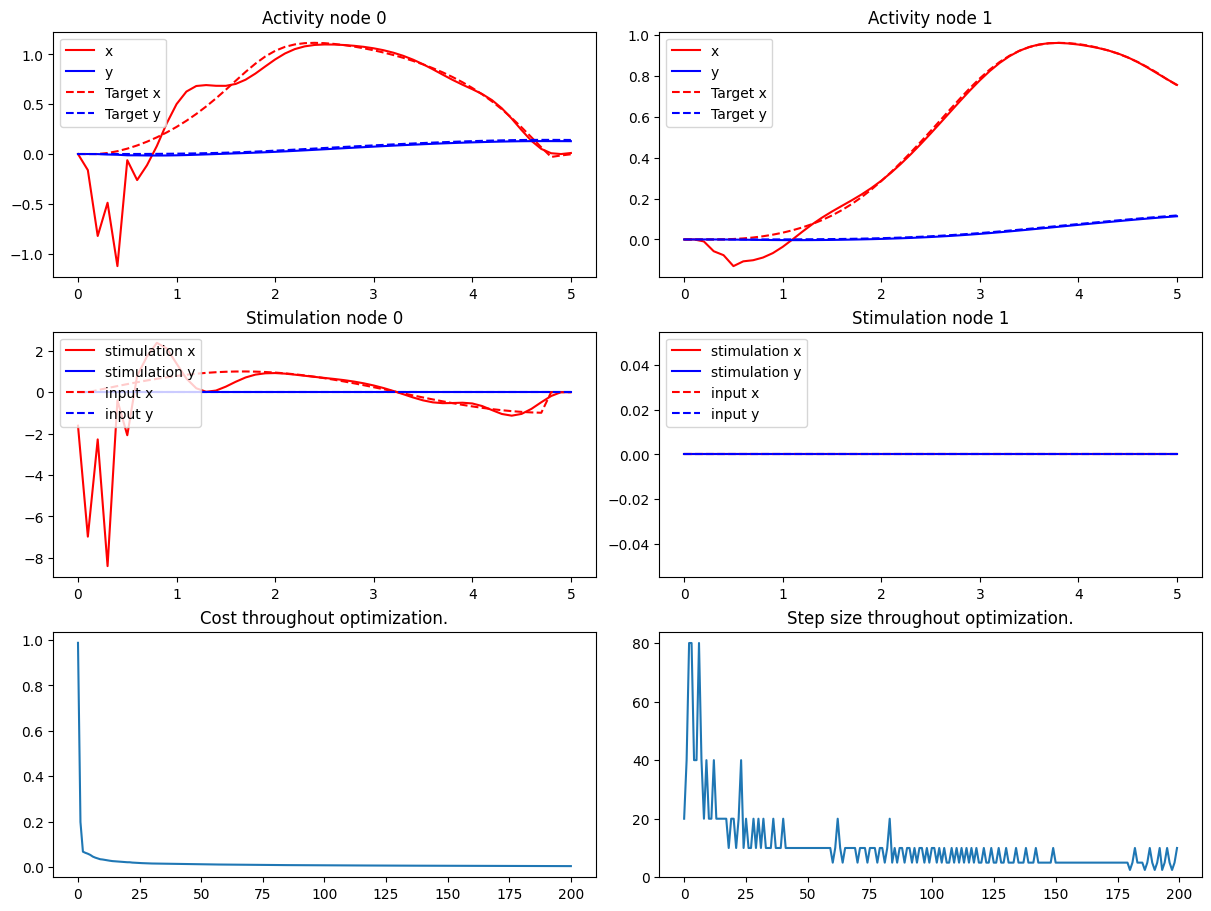

In [89]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

### Delayed network

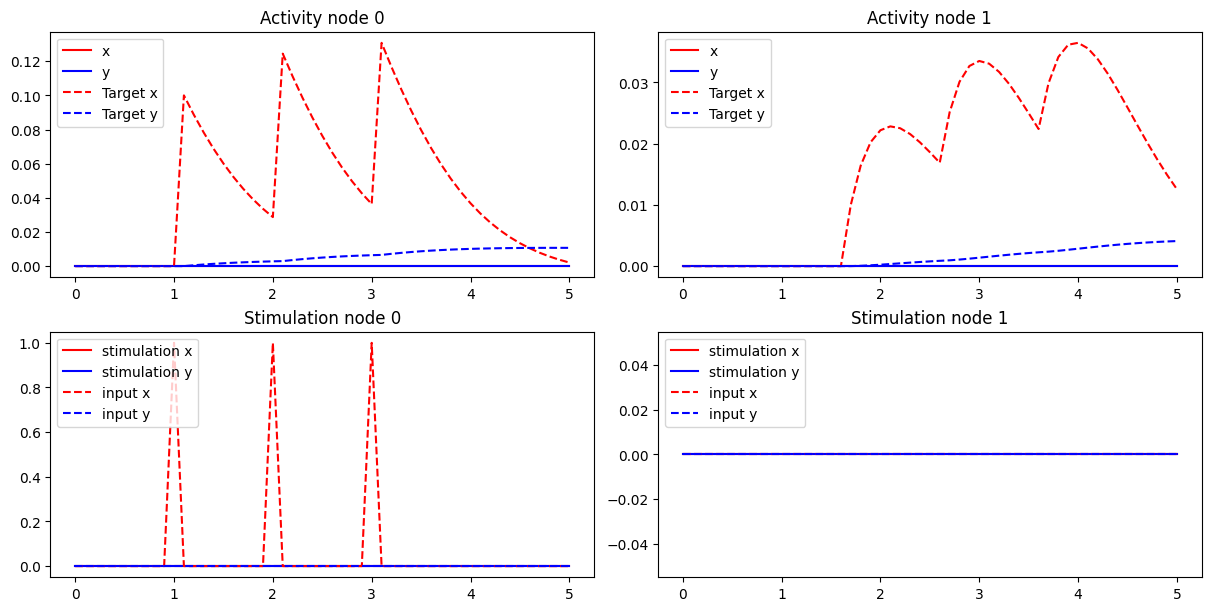

In [93]:
cmat = np.array( [[0., 0.], [1., 0.]] ) # diagonal elements are zero, connection strength is 1 from node 0 to node 1
dmat = np.array( [[0., 0.], [0.5, 0.]] ) # delay from 0 to 1

model = FHNModel(Cmat=cmat, Dmat=dmat)
#model = HopfModel(Cmat=cmat, Dmat=dmat)

duration = 2000.
model.params.duration = duration

# change coupling parameters for faster and stronger connection between nodes
model.params.K_gl = 1.
model.params.signalV = 1.
if model.name == "hopf":
    model.params.a = -1. # only for Hopf model. Parameter "a" does not exist in FHN

model.params.x_ext = np.zeros((1,))
model.params.y_ext = np.zeros((1,))

model.run()

e0 = model.x[0,-1]
e1 = model.x[1,-1]
i0 = model.y[0,-1]
i1 = model.y[1,-1]

model.params["xs_init"] = np.array([[e0, e0, e0, e0, e0, e0], [e1, e1, e1, e1, e1, e1]])
model.params["ys_init"] = np.array([[i0, i0, i0, i0, i0, i0], [i1, i1, i1, i1, i1, i1]])

duration = 5.
model.params.duration = duration
time = np.arange(dt, duration+dt, dt)

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in E-channel in node 0

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,10] = 1. 
input[0,20] = 1.
input[0,30] = 1. # Three pulses as control input

input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["x_ext"] = input_nw[:,0,:]
model.params["y_ext"] = input_nw[:,1,:]

model.params["xs_init"] = np.array([[e0, e0, e0, e0, e0, e0], [e1, e1, e1, e1, e1, e1]])
model.params["ys_init"] = np.array([[i0, i0, i0, i0, i0, i0], [i1, i1, i1, i1, i1, i1]])
model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.stack( (model.params["xs_init"][:,-1], model.params["ys_init"][:,-1]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.stack( (model.params["xs_init"][:,-1], model.params["ys_init"][:,-1]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)
plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Delay not yet implemented, please set delays to zero
Optimal control with target time series
Compute control for a deterministic system
Cost in iteration 0: 0.0011809427403919929
Cost in iteration 1: 5.027273181923504e-05
Cost in iteration 2: 4.261460407395231e-05
Cost in iteration 10: 2.7346886958299187e-05
Cost in iteration 50: 1.2090149347140948e-05
Cost in iteration 100: 6.377808065534598e-06
Final cost : 6.377808065534598e-06


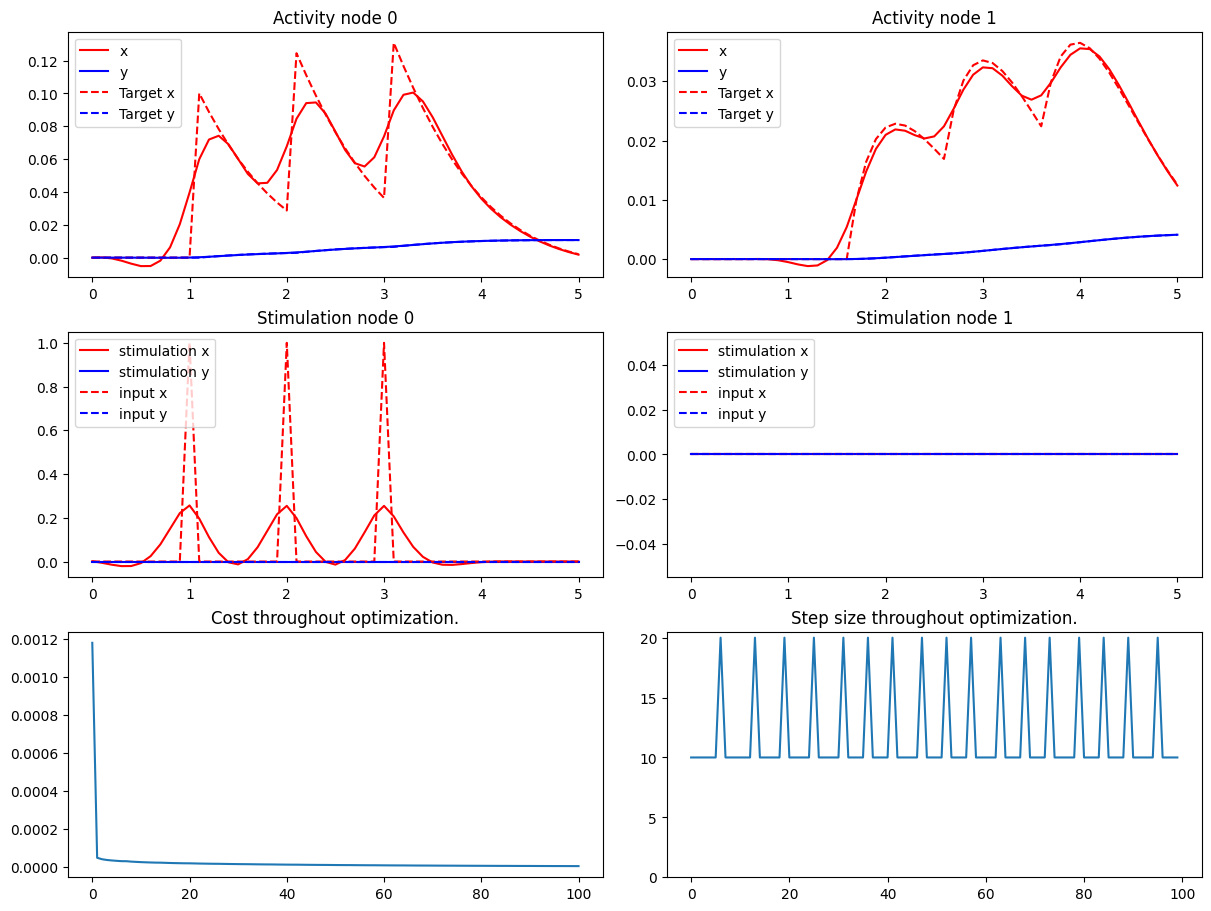

In [94]:
prec_mat = np.zeros( (model.params.N, len(model.output_vars)) )
prec_mat[1,0] = 1. # only measure in y-channel in node 1

if model.name == "fhn":
    model_controlled = oc_fhn.OcFhn(model, target, print_array=[1,2,10,50,100,200,300,400,500, 1000], cost_matrix=prec_mat, control_matrix=control_mat)
elif model.name == "hopf":
    model_controlled = oc_hopf.OcHopf(model, target, print_array=[1,2,10,50,100,200,300,400,500, 1000], cost_matrix=prec_mat, control_matrix=control_mat)
model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 4.667474552785227e-07
Cost in iteration 1: 4.6645566378677137e-07
Cost in iteration 2: 4.662682830491494e-07
Cost in iteration 10: 4.6465639925239315e-07
Cost in iteration 50: 4.5680150591173665e-07
Cost in iteration 100: 4.474348018378922e-07
Final cost : 4.474348018378922e-07


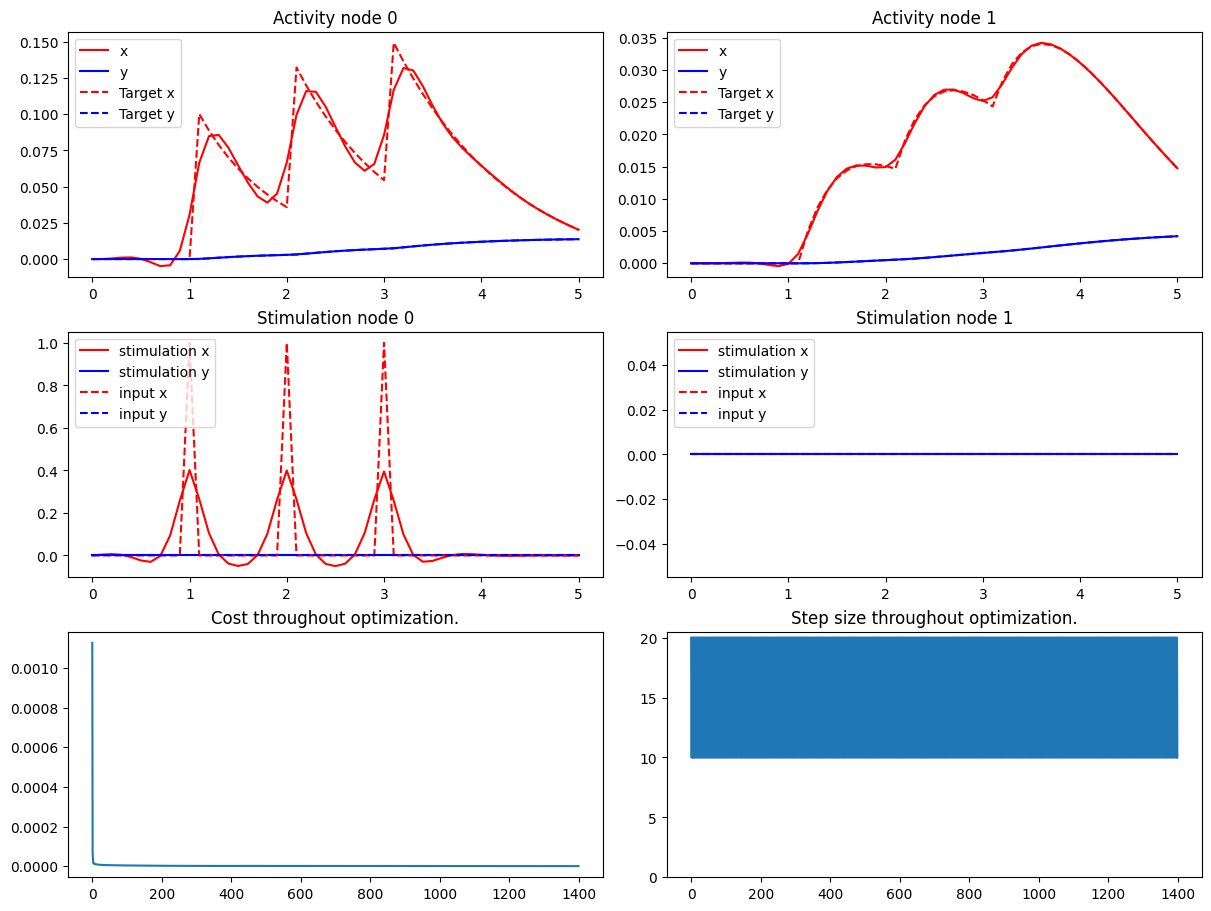

In [84]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)